In [44]:
import numpy as np
import matplotlib.pyplot as plt
import json
import h5py

from skimage.io import imread, imsave
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
windowSize = 128
subDivisions = 2
sigma = 5.0

In [3]:
with open('cells_phEC_v4.json') as json_file:
    data = json.load(json_file)
files = len(data['data'])

raw_images = []
positions = []

for obj in tqdm(data['data'], total=files):
    if len(obj['layers']) > 0:
        positions.append(np.array([[p['y'],p['x']] for p in obj['layers'][0]['points']]))
        raw_images.append(imread(obj['name'])[:,:,0])

n_images = len(raw_images)
        
print(n_images)

100%|███████████████████████████████████████████████████████████████████████████████| 364/364 [00:02<00:00, 149.37it/s]

126


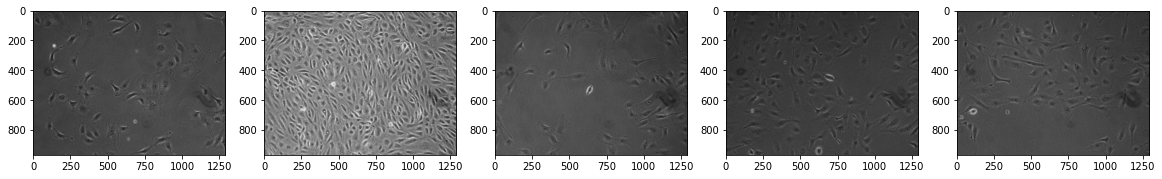

In [4]:
indices = np.random.randint(n_images, size=5)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
for i in range(5):
    axes[i].imshow(raw_images[indices[i]], cmap=plt.cm.gray)

(968, 1292)
(968, 1292)


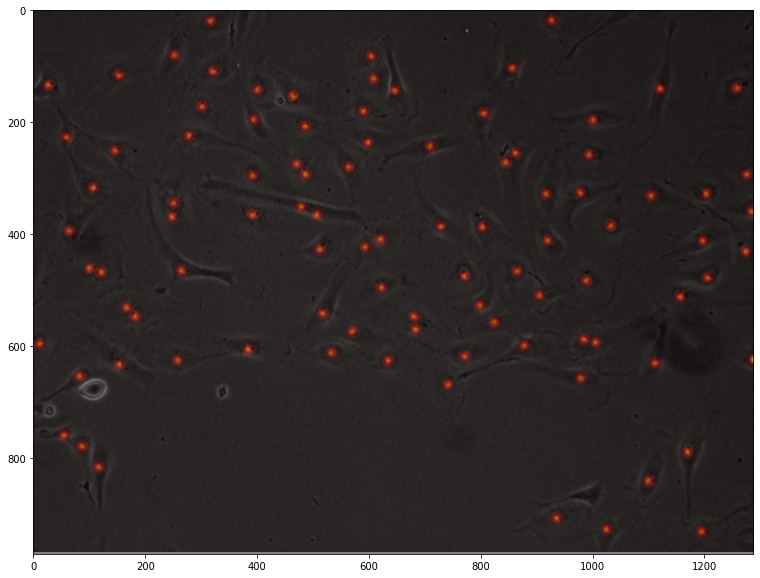

In [33]:
subWindowSize = windowSize // subDivisions

image = raw_images[0]

nx = (image.shape[0] + 2*subWindowSize) // subWindowSize
ny = (image.shape[1] + 2*subWindowSize) // subWindowSize

bx1 = (nx * subWindowSize - image.shape[0]) // 2
bx2 = nx * subWindowSize - image.shape[0] - bx1

by1 = (ny * subWindowSize - image.shape[1]) // 2
by2 = ny * subWindowSize - image.shape[1] - by1

padded = np.pad(image, ((bx1,bx2), (by1,by2)), 'reflect')

xrange = np.arange(0, padded.shape[0]-subWindowSize, subWindowSize)
yrange = np.arange(0, padded.shape[1]-subWindowSize, subWindowSize)
n_patches = xrange.shape[0] * yrange.shape[0]

posx = [x for x in positions[0][:,0]]
posy = [y for y in positions[0][:,1]]

r = [[0, image.shape[0]], [0, image.shape[1]]]

D,_,_ = np.histogram2d(posx, posy, bins=(image.shape[0], image.shape[1]), range=r)
target = gaussian_filter(D, sigma=sigma).astype('float32')

t = np.pad(target, ((bx1,bx2), (by1,by2)), 'reflect')
                                                

print(image.shape)
print(target.shape)

t = t[by1:-by2,bx1:-bx2]

plt.figure(figsize=(15, 10))
plt.imshow(image, cmap=plt.cm.gray)
plt.imshow(t, alpha = 0.5, cmap=plt.cm.hot)

In [35]:
psf_heatmap = np.zeros((35, 35), dtype=np.float32)
psf_heatmap[int(psf_heatmap.shape[0]/2),int(psf_heatmap.shape[1]/2)] = 1.0
psf_heatmap = gaussian_filter(psf_heatmap, sigma=sigma)
norm = np.max(psf_heatmap)

n = n_images * n_patches

train_images = np.zeros((n, 128, 128))
train_targets = np.zeros((n, 128, 128))

offset = 0

for image, pos in tqdm(zip(raw_images, positions),total=n_images):
    img = np.pad(image, ((bx1,bx2), (by1,by2)), 'reflect').astype('float32') / 255.0
    
    assert np.max(img) != 0.0
    
    r = [[0, img.shape[0]], [0, img.shape[1]]]
    D,_,_ = np.histogram2d(pos[:,0], pos[:,1], bins=(img.shape[0], img.shape[1]), range=r)
    target = gaussian_filter(D, sigma=sigma)
    target = np.pad(target, ((bx1,bx2), (by1,by2)), 'reflect').astype('float32') / norm
    
    for y in yrange:
        for x in xrange:
            train_images[offset] = img[x:x+windowSize,y:y+windowSize]
            train_targets[offset] = target[x:x+windowSize,y:y+windowSize]
            offset += 1

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:07<00:00, 16.66it/s]


In [36]:
print(n,offset)

42336 42336


33913
32439
4712
5053
30118


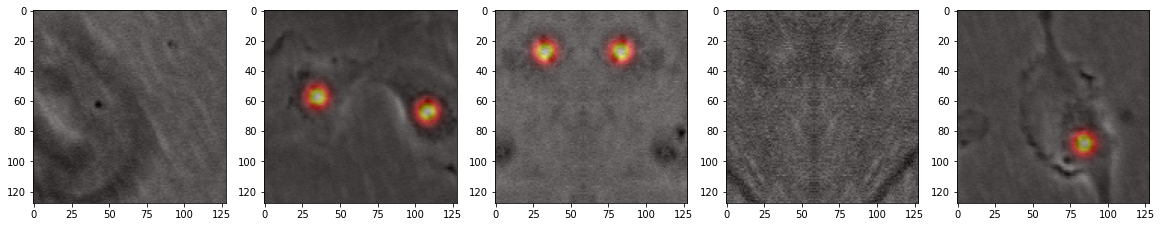

In [43]:
indices = np.random.randint(n, size=5)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
for i in range(5):
    axes[i].imshow(train_images[indices[i]], cmap=plt.cm.gray)
    axes[i].imshow(train_targets[indices[i]], alpha = 0.5, cmap=plt.cm.hot)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_targets,
    test_size=0.1, shuffle = True, random_state = 666)

In [50]:
with h5py.File("trainDataCellCounterSigma5.h5", "w") as f:
    f.create_dataset("X_train", data=X_train.reshape((-1,windowSize,windowSize,1)), compression="gzip", chunks=(1,windowSize,windowSize,1))
    f.create_dataset("Y_train", data=y_train.reshape((-1,windowSize,windowSize,1)), compression="gzip", chunks=(1,windowSize,windowSize,1))
    f.create_dataset("X_val", data=X_test.reshape((-1,windowSize,windowSize,1)), compression="gzip", chunks=(1,windowSize,windowSize,1))
    f.create_dataset("Y_val", data=y_test.reshape((-1,windowSize,windowSize,1)), compression="gzip", chunks=(1,windowSize,windowSize,1))